# Linear Regression with a polynomial expansion

This code is to help us visualize the linear models for polynomials. <br>

This tutorial can be deployed in <a target="_blank" href="https://colab.research.google.com/github/ChemAI-Lab/Math4Chem/blob/main/website/Lecture_Notes/Coding/polynomial_regression_overfitting.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.tri as tri

In [5]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [2]:
# generate random data over f(x) = sin(x) + x - 1
def get_data(N, bool_biased=True):
    # This creates an array x of N linearly spaced values between -1 and 1.
    x = np.linspace(-1., 1., N) + np.random.uniform(low=-.1, high=.1, size=N)
    y = 1.2*np.sin(2*x) + x - 1.
    # Adds random noise to each y value.
    y = y + np.random.uniform(low=-.35, high=.35, size=x.shape)
    if bool_biased:
        X = np.column_stack((np.ones_like(x), x))
    else:
        X = x[:, None]
    return X, y

X, y = get_data(10, bool_biased=True)
print(X)
print(y)

[[ 1.         -1.06347685]
 [ 1.         -0.68778693]
 [ 1.         -0.5101477 ]
 [ 1.         -0.25973886]
 [ 1.         -0.20146866]
 [ 1.          0.19381279]
 [ 1.          0.32576319]
 [ 1.          0.59232235]
 [ 1.          0.76722316]
 [ 1.          1.0286928 ]]
[-2.94217453 -3.03121307 -2.74934505 -1.89567519 -1.32641261 -0.68287178
  0.3952404   0.47035372  1.16481165  0.80801398]


## Exact Solution of Linear Regression ##

* **Gradient of a function equal to zero means a maxima or minima**
  
$$
    \nabla {\cal L}(\mathbf{w}) \Big\rvert_{\mathbf{w}^{*}} = \frac{1}{2n} \nabla_{\mathbf{w}} \left [ \left (\mathbf{y} - \mathbf{X}\mathbf{w} \right)^\top \left (\mathbf{y} - \mathbf{X}\mathbf{w} \right) \right ]= 0
$$

To solve for $\mathbf{w}^*$, let's expand $ \left (\mathbf{y} - \mathbf{X}\mathbf{w} \right)^\top \left (\mathbf{y} - \mathbf{X}\mathbf{w} \right)$,

$$
    \left (\mathbf{y} - \mathbf{X}\mathbf{w} \right)^\top \left (\mathbf{y} - \mathbf{X}\mathbf{w} \right) = \mathbf{y}^\top \mathbf{y}  - \mathbf{y}^\top \mathbf{X}\mathbf{w} -  \mathbf{w}^\top\mathbf{X}^\top\mathbf{y} +   \mathbf{w}^\top\mathbf{X}^\top \mathbf{X}\mathbf{w}
$$
$$
    \nabla_{\mathbf{w}} {\cal L}(\mathbf{w}) = \frac{1}{2n}\left(  -2 \mathbf{X}^\top\mathbf{y} + 2\mathbf{X}^\top\mathbf{X}\mathbf{w} \right) = 0
$$

## Optimal parameters ##

$$
 \mathbf{w}^* = \left ( \mathbf{X}^\top \mathbf{X} \right ) ^{-1} \mathbf{X}^\top \mathbf{y}
$$

**Extra:**
1. Homework, Proof the above equations.
2. [Equations from Sections 2.4.1 and 2.4.2](https://www2.imm.dtu.dk/pubdb/edoc/imm3274.pdf)

In [3]:
# trining a linear model
def linear_model_solver(X, y):
    Xt = X.T
    A = Xt@X
    z = Xt@y
    A_inv = np.linalg.inv(A)
    w = A_inv@z
    return w  # optimal parameters

In [6]:
# find the optimal parameters
w_opt = linear_model_solver(X, y)

y_data_pred = X@w_opt
r2_linear_model = r2_score(y,y_data_pred)
print('R-squared score: ', r2_linear_model)


R-squared score:  0.9248762075335489


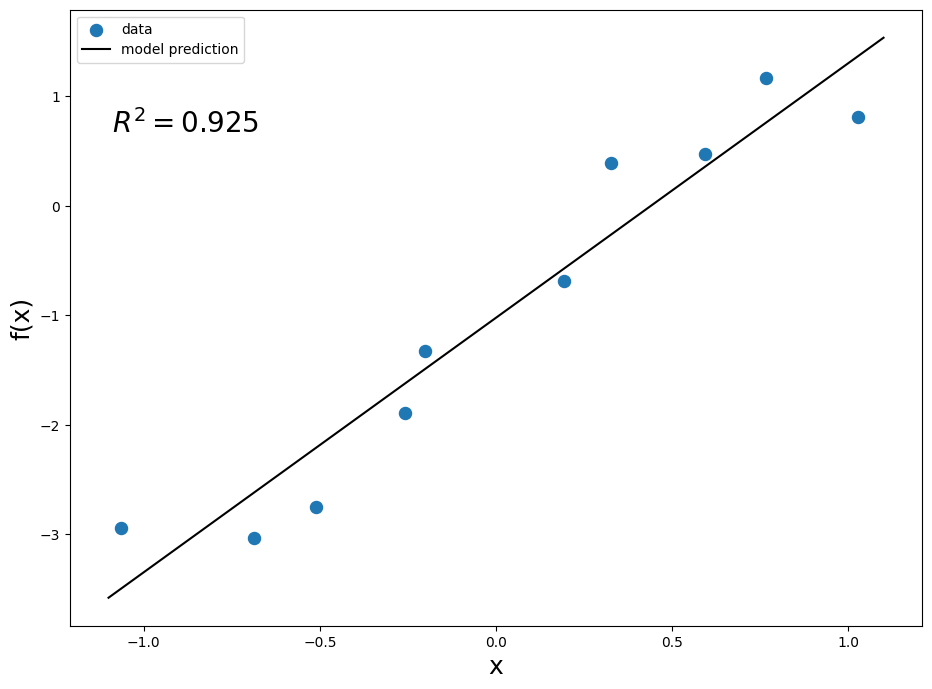

In [7]:
# plot our model
X_grid = np.linspace(-1.1,1.1,100)
X_grid = np.column_stack((np.ones_like(X_grid),X_grid) )
y_pred = X_grid@w_opt

# plot the data
fig, ax = plt.subplots(figsize=(11, 8))
ax.text(0.05,0.8,r'$R^2 = $' + f'{r2_linear_model:0.3f}',transform=ax.transAxes,fontsize=20)
ax.scatter(X[:, 1], y, label='data', s=75)
ax.plot(X_grid[:, 1], y_pred, c='k',label='model prediction', markersize=5)
ax.set_xlabel('x',fontsize=18)
ax.set_ylabel('f(x)', fontsize=18)
plt.legend()

# Beyond Linear Models

Let's revise polynomials:

How many terms if we have a second-order polynomial and $d=3$?
$$
\begin{align}
(1+x_1+x_2+x_3)^3 &= (1+x_1+x_2+x_3)(1+x_1+x_2+x_3)^2 \\
&= 1+3x_1+3x^2_1+x^3_1+3x_2+6x_1x_2+3x^2_1x_2 \\ 
& +3x_2^2+3x_1x_2^2+x_2^3 +3x_3+6x_1x_3+3x_1^2x_3 \\
& +6x_2x_3+6x_1x_2x_3+3x_2^2x_3+3x_3^2 \\
& +3x_1x_3^2+3x_2x_3^2+x_3^3
\end{align}
$$

This is simply a new representation of $x$
$$
\phi(\mathbf{x}) = [1, x_1, x_2, x_3, \cdots, x_i x_j, \cdots, x_i^{ m} x_j^{p}, \cdots, x_i^{ m} x_j^{p}x_{\ell}^{r}]
$$

**Linear models on basis-set expansion**

$$
    f(\mathbf{x},\mathbf{w}) = \sum_{i=0}^d w_i \phi(\mathbf{x}) = \mathbf{w}^\top \phi(\mathbf{x})
$$


* **Loss function**,
$$
    \begin{align}
    {\cal L}(\mathbf{w}) &= \frac{1}{2n}\sum_i^N (y_i - f(\mathbf{x}_i,\mathbf{w}))^2 = \frac{1}{2}\sum_i^N (y_i - \mathbf{w}^\top \phi(\mathbf{x}_i))^2 \\
    &= \frac{1}{2n} \left (\mathbf{y} - \Phi(\mathbf{x})\mathbf{w} \right)^\top \left (\mathbf{y} -  \Phi(\mathbf{x})\mathbf{w} \right)
    \end{align}
$$
Homework, proof the above equations.


1. What is $\Phi(\mathbf{x})$?
2. What is the form of the **optimal** parameters $\mathbf{w}^*$?

Instead of coding how to create the polynomial representation, we will use Sklearn. <br>
Read the documentation: [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In [8]:
def polynomial_features(X, p):
    # transform the input data to polynomial features up to degree p
    poly = PolynomialFeatures(p)
    Phi = poly.fit_transform(X)
    return Phi

In [10]:
# x = np.ones((1,1))
x = np.random.normal(-1.,0.1,size=(1,1))
print(f'Original x \n{x}')
for p in range(1,4):
    x_phi = polynomial_features(x,p)
    print(f'For degree {p}, the polynomial features are:\n{x_phi}')

Original x 
[[-0.78934184]]
For degree 1, the polynomial features are:
[[ 1.         -0.78934184]]
For degree 2, the polynomial features are:
[[ 1.         -0.78934184  0.62306054]]
For degree 3, the polynomial features are:
[[ 1.         -0.78934184  0.62306054 -0.49180776]]


In [11]:
# transform the training data to polynomial features
p = 3

X = X[:,-1:] # select the last column
print(X)
X_phi = polynomial_features(X, p)
print(X)
print(X_phi)
w_phi_opt = linear_model_solver(X_phi, y)
print(f'Optimal parameters\n{w_phi_opt}')

y_data_phi_pred = X_phi@w_phi_opt
r2_score_poly = r2_score(y, y_data_phi_pred)
print(f'R-squared score for the polynomial model: {r2_score_poly}')

[[-1.06347685]
 [-0.68778693]
 [-0.5101477 ]
 [-0.25973886]
 [-0.20146866]
 [ 0.19381279]
 [ 0.32576319]
 [ 0.59232235]
 [ 0.76722316]
 [ 1.0286928 ]]
[[-1.06347685]
 [-0.68778693]
 [-0.5101477 ]
 [-0.25973886]
 [-0.20146866]
 [ 0.19381279]
 [ 0.32576319]
 [ 0.59232235]
 [ 0.76722316]
 [ 1.0286928 ]]
[[ 1.         -1.06347685  1.13098302 -1.20277426]
 [ 1.         -0.68778693  0.47305086 -0.3253582 ]
 [ 1.         -0.5101477   0.26025067 -0.13276628]
 [ 1.         -0.25973886  0.06746428 -0.01752309]
 [ 1.         -0.20146866  0.04058962 -0.00817754]
 [ 1.          0.19381279  0.0375634   0.00728027]
 [ 1.          0.32576319  0.10612166  0.03457053]
 [ 1.          0.59232235  0.35084577  0.20781379]
 [ 1.          0.76722316  0.58863138  0.45161162]
 [ 1.          1.0286928   1.05820888  1.08857186]]
Optimal parameters
[-0.98446496  3.52990339 -0.10635409 -1.5577388 ]
R-squared score for the polynomial model: 0.979201592239008


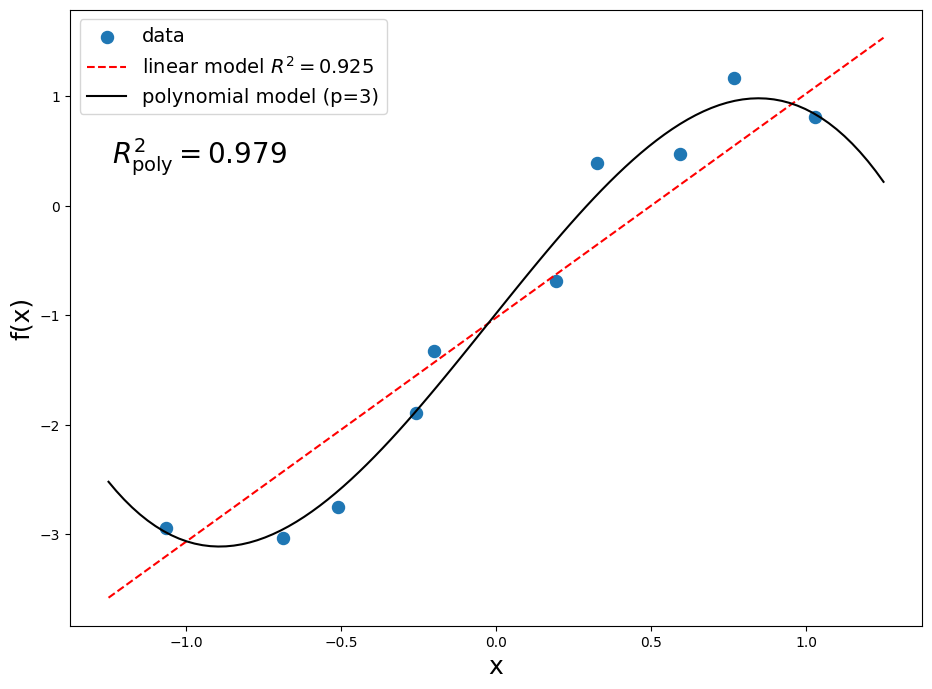

In [12]:
X_grid = np.linspace(-1.25,1.25,100)
X_grid = X_grid[:,None]

X_grid_phi = polynomial_features(X_grid, p)
y_pred_phi = X_grid_phi@w_phi_opt

# plot the data and the polynomial model
fig, ax = plt.subplots(figsize=(11, 8))
ax.text(0.05, 0.75, r'$R^2_{\text{poly}} = $' +
        f'{r2_score_poly:0.3f}', transform=ax.transAxes, fontsize=20)
ax.scatter(X[:, 0], y, label='data', s=75)
ax.plot(X_grid[:, 0], y_pred, c='red', ls = '--',
        label='linear model ' + r'$R^2 = $' +
        f'{r2_linear_model:0.3f}', markersize=5)
ax.plot(X_grid[:, 0], y_pred_phi, c='k',label=f'polynomial model (p={p})', markersize=5)
ax.set_xlabel('x',fontsize=18)
ax.set_ylabel('f(x)', fontsize=18)
plt.legend(fontsize=14)

degree: 2, R2= 0.9248972029899004
degree: 4, R2= 0.9796120426802579
degree: 6, R2= 0.9831363848366019
degree: 8, R2= 0.9922085462854567
degree: 10, R2= 0.9904987023139902


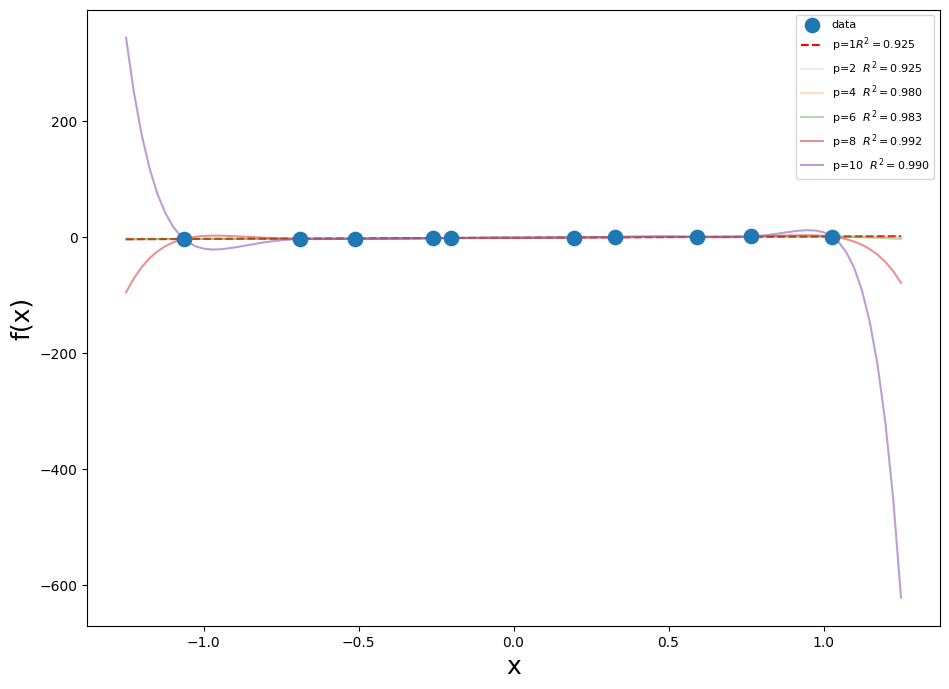

In [16]:
# R2 as a function of the polynomial degree
p = 4
X = X[:, -1:]  # select the last column

X_grid = np.linspace(-1.25, 1.25, 100)
X_grid = X_grid[:, None]

fig, ax = plt.subplots(figsize=(11, 8))
ax.scatter(X[:, 0], y, label='data', s=105,zorder=4)
ax.plot(X_grid[:, 0], y_pred, c='red', ls='--',
        label='p=1' + r'$R^2 = $' +
        f'{r2_linear_model:0.3f}', markersize=5)
    
for p in range(2,11,2):

    X_phi = polynomial_features(X, p)
    w_phi_opt = linear_model_solver(X_phi, y)
    # print(f'Optimal parameters\n{w_phi_opt}')

    y_data_phi_pred = X_phi@w_phi_opt
    r2_score_poly = r2_score(y, y_data_phi_pred)
    print(f'degree: {p}, R2= {r2_score_poly}')

    X_grid_phi = polynomial_features(X_grid, p)
    y_pred_phi = X_grid_phi@w_phi_opt
# plot the data and the polynomial model

    ax.plot(X_grid[:, 0], y_pred_phi,
            label=f'p={p} ' +  r' $R^2 = $' +
            f'{r2_score_poly:0.3f}',  markersize=5, alpha=0.95*p/15)
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('f(x)', fontsize=18)
plt.legend(fontsize=8,loc=0)

## The Challenge of Overfitting

- **Risk in Flexibility**:  Higher-degree polynomials might fit the training data too precisely, capturing noise rather than the underlying trend, a phenomenon known as overfitting.
- **Consequences**: An overfitted model performs poorly on new, unseen data, rendering it less effective for predictive purposes.

<br>


>#### **Learn More:**
1. **What is Overfitting**: [Educational Resource](https://www.v7labs.com/blog/overfitting)
2. **Regularization in Machine Learning (with Code Examples)**: [Example Application](https://www.dataquest.io/blog/regularization-in-machine-learning/)
3. **Polynomial Regression**: [Educational Resource](https://medium.com/analytics-vidhya/polynomial-regression-%EF%B8%8F-e0e20bfbe9d5)